# Convolutional Neural Networks in Pytorch

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Setup MNIST Dataset

In [4]:
# MNIST Image -->
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='./../../data/',
                            train=True,
                            download=True,
                            transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./../../data/MNIST\raw\train-images-idx3-ubyte.gz to ./../../data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./../../data/MNIST\raw\train-labels-idx1-ubyte.gz to ./../../data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./../../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./../../data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./../../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./../../data/MNIST\raw



In [7]:
test_data = datasets.MNIST(root='./../../data/',
                            train=False,
                            download=True,
                            transform=transform)

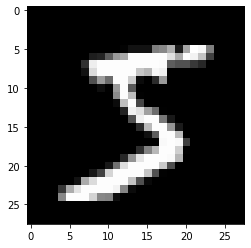

In [11]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap='gray')

In [12]:
# Batch data
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [13]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # Formatting / Making spaces of arrays wider

In [15]:
# First batch.
for images, labels in train_loader:
    break

images.shape

torch.Size([100, 1, 28, 28])

Lables:  [   7    1    6    9    5    0    7    1    1    9    5    7]


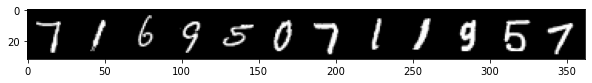

In [19]:
# Print out first 12 images.
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10, 4))
# Print first 12 lables.
print('Lables: ', labels[:12].numpy())
# Convert from Color/Width/Height to Width/Height/Color
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Classification Using a Traditional Artificial Neural Network

In [20]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) # Multiclass classifications.

In [24]:
torch.manual_seed(101)
model = MultilayerPerceptron()
total_parameter_count = sum([p.numel() for p in model.parameters()])

print(f'Total Model Parameters: {total_parameter_count}') # using a CNN later on will reduce this and make our solution more efficient.

Total Model Parameters: 105214


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
images.shape # We need to make this a single dimension first.

torch.Size([100, 1, 28, 28])

In [31]:
flatten_images = images.view(100, -1)
flatten_images.shape

torch.Size([100, 784])

In [34]:
import time
start_time = time.time()

# Trackers
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            accuracy = trn_correct.item()*100/(100*b)
            print(f'Epoch {i}, Batch: {b}, Loss: {loss.item()}, Accuracy: {accuracy}')
            
    train_losses.append(loss)
    train_correct.append(trn_correct)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_correct += (predicted==y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0, Batch: 200, Loss: 0.23706978559494019, Accuracy: 92.085
Epoch 0, Batch: 400, Loss: 0.20322780311107635, Accuracy: 92.845
Epoch 0, Batch: 600, Loss: 0.17192453145980835, Accuracy: 93.41
Epoch 1, Batch: 200, Loss: 0.13874953985214233, Accuracy: 95.385
Epoch 1, Batch: 400, Loss: 0.03966035693883896, Accuracy: 95.6975
Epoch 1, Batch: 600, Loss: 0.11272921413183212, Accuracy: 95.86833333333334
Epoch 2, Batch: 200, Loss: 0.13577748835086823, Accuracy: 96.99
Epoch 2, Batch: 400, Loss: 0.13789188861846924, Accuracy: 96.9575
Epoch 2, Batch: 600, Loss: 0.10913985222578049, Accuracy: 96.995
Epoch 3, Batch: 200, Loss: 0.12744760513305664, Accuracy: 97.71
Epoch 3, Batch: 400, Loss: 0.009579071775078773, Accuracy: 97.705
Epoch 3, Batch: 600, Loss: 0.06177245453000069, Accuracy: 97.61833333333334
Epoch 4, Batch: 200, Loss: 0.055195122957229614, Accuracy: 98.205
Epoch 4, Batch: 400, Loss: 0.059597112238407135, Accuracy: 98.1825
Epoch 4, Batch: 600, Loss: 0.043776735663414, Accuracy: 98.165
Ep

## Evaluation (ANN)

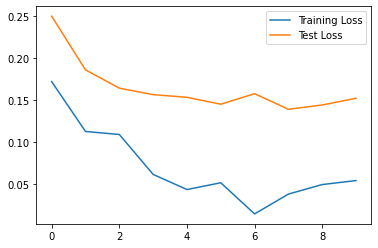

In [39]:
with torch.no_grad():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()

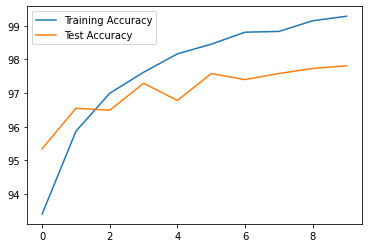

In [45]:
train_accuracy = [t/600 for t in train_correct]
test_accuracy = [t/100 for t in test_correct]

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()

In [49]:
# Evaluate Unseen Data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted==y_test).sum()

# Accuracy
correct.item() / len(test_data) * 100

97.81

In [50]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 969,    0,    3,    1,    1,    2,    3,    0,    4,    2],
       [   0, 1124,    2,    0,    0,    0,    3,    5,    0,    2],
       [   1,    3, 1012,    4,    1,    0,    6,   10,    5,    0],
       [   3,    2,    4,  992,    0,    7,    1,    4,    9,    8],
       [   1,    0,    1,    0,  953,    2,    3,    3,    1,    6],
       [   0,    1,    0,    8,    1,  872,    4,    2,    5,    3],
       [   1,    2,    0,    0,    5,    3,  937,    0,    2,    0],
       [   1,    0,    1,    3,    1,    1,    0,  997,    3,    0],
       [   2,    3,    8,    2,    3,    4,    1,    2,  941,    4],
       [   2,    0,    1,    0,   17,    1,    0,    5,    4,  984]],
      dtype=int64)